# AB Testing: Mobile Gaming & User Retention


**Situation**: Cookie Cats is a popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. As players progress through the levels of the game, they occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates function as a forced break, hopefully prolonging engagement. 

**Task**: The game developers want to improve player retention. To that aim they're considering moving the first gate from level 30 to 40. 

**Action**: To inform their decision we'll conduct an AB test to determine which placement results in the best player retention. 

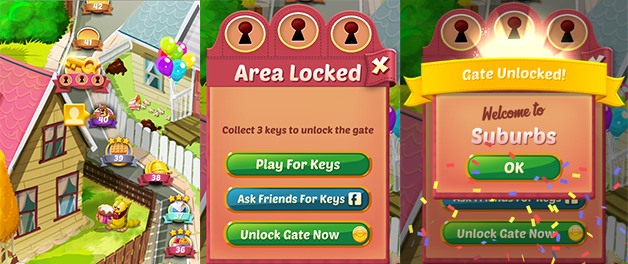

## Setup: Load Data & Packages

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format 

In [2]:
ab = pd.read_csv('/Users/aidan/Documents/Python Storage/AB Testing Demo/cookie_cats.csv')

In [3]:
ab.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Previewing the data we see a summary of available factors, data types, and confirm there's no missing data that may skew our analysis.

**Data**:
- userid: A unique number that identifies each player
- version: Whether the player was in the control group (gate_30) or the group with the moved gate (gate_40)
- sum_gamerounds: The number of game rounds played by the player during the first 14 days after install.
- retention_1: Did the player come back and play 1 day after installing, true/false
- retention_7: Did the player come back and play 7 days after installing. true/false


We'll also confirm if the size of each group is symmetrical and check for any outliers that may skew our findings.

In [5]:
ab.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


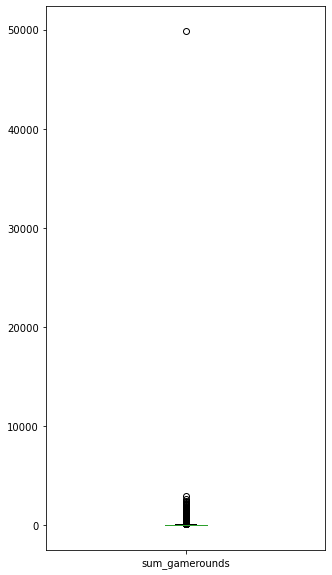

In [6]:
ab['sum_gamerounds'].plot.box(figsize=(5,10))

Apparently there's one very extreme outlier. We'll exclude it from analysis to ensure the integrity of our findings.

## Initial Analysis

In [7]:
ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


In [8]:
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17,51.3421,102.0576,2961
gate_40,45489,16,51.2988,103.2944,2640


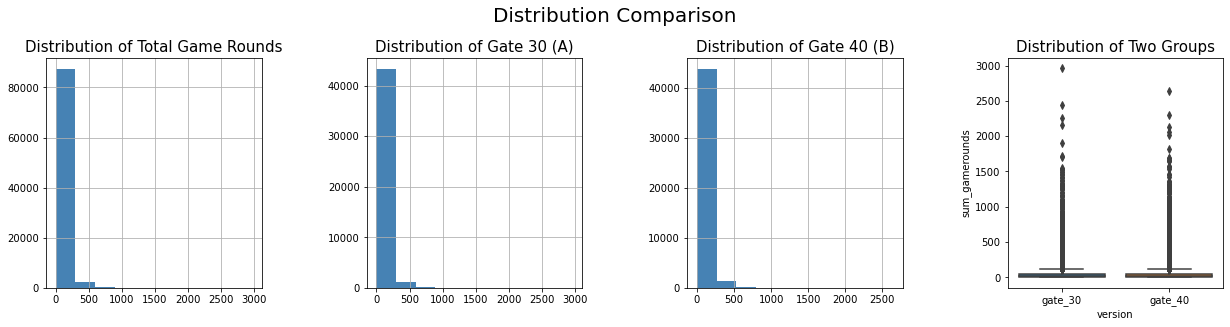

In [9]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
ab.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[3])

plt.suptitle("Distribution Comparison", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

#### Player Retention

The focus of this analysis is on how gate placements affect player retention, but to provide context we'll plot the player distribution over game rounds played during the first week. This chart will display the general trend for player retention.

Text(0.5, 0, '# Game rounds')

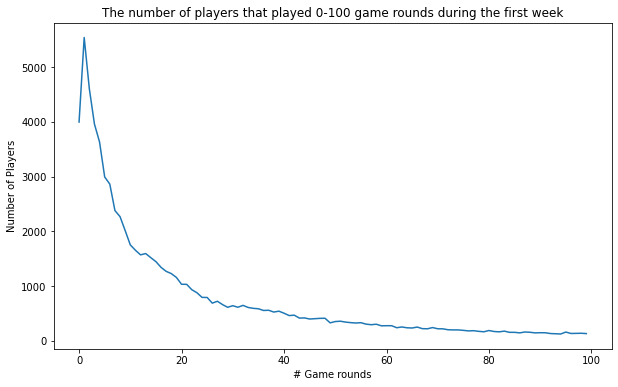

In [10]:
# Plot the distribution of players that played 0 to 100 game rounds during their first week playing the game.
plot_df = ab.groupby('sum_gamerounds')['userid'].count()

ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

The distribution is highly skewed, with a long tail on the right. The majority of players completed fewer than 20 rounds although it appears there are enough committed players to maintain a floor to player count. Another insight is that a large number of players installed the game but never played. This finding suggests additional analysis but for now we'll continue AB testing the gate placement.

In [11]:
df_retention = ab[["retention_1","retention_7"]].mean()*100
print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


Little less than half of the players come back one day after installing the game. 18 percent of the players come back 7 day after installing the game.

With this benchmark we can now look at how retention rates differ between the two A/B groups.

In [13]:
# Calculating 1-day and 7-days retention for each A/B group
df_retention_ab = ab.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44699,0.4482,0.1902,2294941
gate_40,45489,0.4423,0.1820,2333530


There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control group when it was at level 30 (44.8%).

Again,a decrease in 7-day retention when the gate was moved to level 40 (18.2%) compared to the control group when it was at level 30 (19.8%).

It's a small change, but even small changes in retention can have a large impact over time. While we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are numerous methods to determine the certainty of these retention numbers. First we will use bootstrapping.

## AB Testing: Bootstrapping

We'll use bootstrapping for A/B testing. The basic idea of bootstrapping is that inference about a population from sample data (sample → population) can be modelled by resampling the sample data and performing inference about a sample from resampled data (resampled → sample). As the population is unknown, the true error in a sample statistic against its population value is unknown. In bootstrap-resamples, the 'population' is in fact the sample, and this is known; hence the quality of inference of the 'true' sample from resampled data (resampled → sample) is measurable

**Testing Steps**:

- Creating 500 samples of dataset (bootstrapping)
- Calculating 1-day & 7-days retentions for A/B groups
- Plotting the bootstrap distributions
- Calculating retention rate difference between the two A/B groups
- Calculating the probability that 1-day & 7-days retentions are greater when the gate is at level 30
- Evaluating results and making recommendation

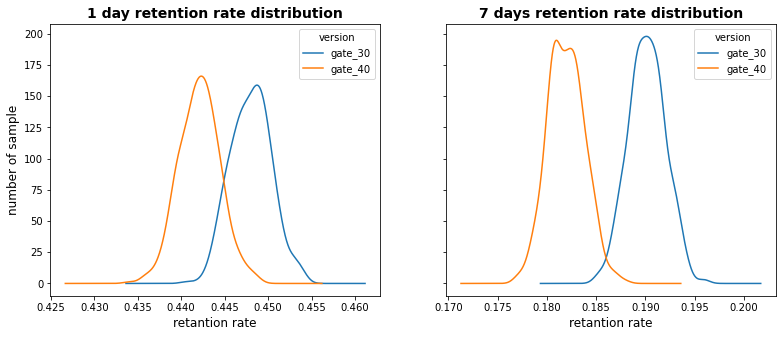

In [15]:
# Creating an list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = ab.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = ab.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retention rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retention rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day & 7-days retention could be for the two A/B groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the differences.

(Note that in this notebook we have limited the number of bootstrap replication to 500 to keep the calculations quick. In "production" we would likely increase this to a much larger number, say, 10 000.)

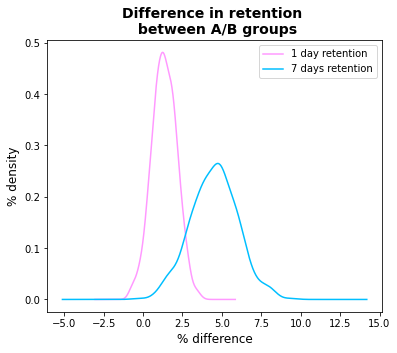

In [18]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

In [20]:
boot_1d['diff'].mean()

1.3446595708412243

In [21]:
boot_7d['diff'].mean()

4.510240606274317

In this chart we can see that the likely percent difference in player retention is: 1.34% for 1-day retention, and 4.51% for 7-day retention. Moreover, both distributions are centered above 0% suggesting gate placement at level 30 improves player retention over each time period. Although these findings are encouraging we need to confirm this effect is not due to chance. To do so we'll calculate the probability that the difference is above 0%.  

In [17]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Calculating the probability that 7-days retention is greater when the gate is at level 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Pretty printing the probability
print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1,2)*100}% \
      \nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ")

The probability that 1-day retention is greater when the gate is at level 30: 95.0%       
The probability that 7-days retention is greater when the gate is at level 30: 99.8% 


## Results 

The bootstrap results provide strong evidence, 95.0% & 99.8% probability respectively, that 1-day and 7 day retention is greater when the gate is at level 30 compared to level 40. Findings also suggest we can expect level 30 gate placement to improve player retention by 1.34% over 1-day and 4.51% over 7-days. We conclude by recommending the gate remain at level 30 to improve player retention. 

**Additional Thoughts**

There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.

So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of hedonic adaptation can give one explanation for this.

In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.

## Alternative AB Testing Methods 

**Assumptions**:

Check normality
If Normal Distribution, check homogeneity

**Steps**:

Split & Define Control Group & Test Group
Apply Shapiro Test for normality
If parametric apply Levene Test for homogeneity of variances
If Parametric + homogeneity of variances apply T-Test
If Parametric - homogeneity of variances apply Welch Test
If Non-parametric apply Mann Whitney U Test directly

In [ ]:
# Define A/B groups
ab["version"] = np.where(ab.version == "gate_30", "A", "B")
ab.head()

In [ ]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=ab, group = "version", target = "sum_gamerounds")

 After applying these alternative methods, the result gives us some important information. Shapiro Testing rejected H0 for Normality assumption. Therefore we needed to apply a Non-parametric test called the Mann Whitney U test to compare the two groups. As a result, Mann Whitney U Testing rejected the H0 hypothesis and we learned A/B groups are not similar.

Briefly, there are statistically significant differences between gate placement at level 30 compared to level 40. 

In [22]:
ab.groupby("version").retention_1.mean(), ab.groupby("version").retention_7.mean()

(version
 gate_30   0.4482
 gate_40   0.4423
 Name: retention_1, dtype: float64,
 version
 gate_30   0.1902
 gate_40   0.1820
 Name: retention_7, dtype: float64)

The gate should be at level 30 as average retention is greater in both time periods compared to level 40. 